# Test VAE on Synthetic Data

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import tensorflow as tf
import time
from tensorflow.python.client import timeline
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
FLAGS = tf.app.flags.FLAGS
# number of device count
tf.app.flags.DEFINE_integer('num_cpu_core', 1, 'Number of CPU cores to use')
tf.app.flags.DEFINE_integer('intra_op_parallelism_threads', 1, 'How many ops can be launched in parallel')
tf.app.flags.DEFINE_integer('num_gpu_core', 0, 'Number of GPU cores to use')

device_id = -1 # Global Variable Counter for device_id used

def next_device(use_cpu = True):
    ''' See if there is available next device;
        Args: use_cpu, global device_id
        Return: new device id
    '''
    global device_id
    if (use_cpu):
        if ((device_id + 1) < FLAGS.num_cpu_core):
            device_id += 1
        device = '/cpu:%d' % device_id
    else:
        if ((device_id + 1) < FLAGS.num_gpu_core):
            device_id += 1
        device = '/gpu:%d' % device_id
    return device

### Define VAE

In [3]:
def xavier_init(neuron_in, neuron_out, constant=1):
    low = -constant*np.sqrt(6/(neuron_in + neuron_out))
    high = constant*np.sqrt(6/(neuron_in + neuron_out))
    return tf.random_uniform((neuron_in, neuron_out), minval=low, maxval=high, dtype=tf.float32)

def init_weights(config):
    """
    Initialize weights with specified configuration using Xavier algorithm
    """
    encoder_weights = dict()
    decoder_weights = dict()
    
    # two layers encoder
    encoder_weights['h1'] = tf.Variable(xavier_init(config['x_in'], config['encoder_1']))
    encoder_weights['h2'] = tf.Variable(xavier_init(config['encoder_1'], config['encoder_2']))
    encoder_weights['mu'] = tf.Variable(xavier_init(config['encoder_2'], config['z']))
    encoder_weights['sigma'] = tf.Variable(xavier_init(config['encoder_2'], config['z']))
    encoder_weights['b1'] = tf.Variable(tf.zeros([config['encoder_1']], dtype=tf.float32))
    encoder_weights['b2'] = tf.Variable(tf.zeros([config['encoder_2']], dtype=tf.float32))
    encoder_weights['bias_mu'] = tf.Variable(tf.zeros([config['z']], dtype=tf.float32))
    encoder_weights['bias_sigma'] = tf.Variable(tf.zeros([config['z']], dtype=tf.float32))
    
    # two layers decoder
    decoder_weights['h1'] = tf.Variable(xavier_init(config['z'], config['decoder_1']))
    decoder_weights['h2'] = tf.Variable(xavier_init(config['decoder_1'], config['decoder_2']))
    decoder_weights['mu'] = tf.Variable(xavier_init(config['decoder_2'], config['x_in']))
    decoder_weights['sigma'] = tf.Variable(xavier_init(config['decoder_2'], config['x_in']))
    decoder_weights['b1'] = tf.Variable(tf.zeros([config['decoder_1']], dtype=tf.float32))
    decoder_weights['b2'] = tf.Variable(tf.zeros([config['decoder_2']], dtype=tf.float32))
    decoder_weights['bias_mu'] = tf.Variable(tf.zeros([config['x_in']], dtype=tf.float32))
    decoder_weights['bias_sigma'] = tf.Variable(tf.zeros([config['x_in']], dtype=tf.float32))
    
    return (encoder_weights, decoder_weights)


def forward_z(x, encoder_weights):
    """
    Compute mean and sigma of z
    """
    with tf.device(next_device()):
        layer_1 = tf.nn.softplus(tf.add(tf.matmul(x, encoder_weights['h1']), encoder_weights['b1']))
    with tf.device(next_device()):
        layer_2 = tf.nn.softplus(tf.add(tf.matmul(layer_1, encoder_weights['h2']), encoder_weights['b2']))
    z_mean = tf.add(tf.matmul(layer_2, encoder_weights['mu']), encoder_weights['bias_mu'])
    z_sigma = tf.add(tf.matmul(layer_2, encoder_weights['sigma']), encoder_weights['bias_sigma'])
    
    return(z_mean, z_sigma)


def reconstruct_x(z, decoder_weights):
    """
    Use z to reconstruct x
    """
    with tf.device(next_device()):
        layer_1 = tf.nn.softplus(tf.add(tf.matmul(z, decoder_weights['h1']), decoder_weights['b1']))
    with tf.device(next_device()):
        layer_2 = tf.nn.softplus(tf.add(tf.matmul(layer_1, decoder_weights['h2']), decoder_weights['b2']))
    x_prime = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, decoder_weights['mu']), decoder_weights['bias_mu']))
    
    return x_prime


def optimize_func(z, z_mean, z_sigma, x, x_prime, learn_rate):
    """
    Define cost and optimize function
    """
    # define loss function
    # reconstruction lost
    recons_loss = -tf.reduce_sum(x * tf.log(1e-10 + x_prime) + (1-x) * tf.log(1e-10 + 1 - x_prime), 1)
    # KL distance
    latent_loss = -0.5 * tf.reduce_sum(1 + z_sigma - tf.square(z_mean) - tf.exp(z), 1)
    # summing two loss terms together
    cost = tf.reduce_mean(recons_loss + latent_loss)
    
    # use ADAM to optimize
    optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate).minimize(cost)
    
    return (cost, optimizer)

def vae_init(batch_size=100, learn_rate=0.001, config={}):
    """
    This function build a varational autoencoder based on https://jmetzen.github.io/2015-11-27/vae.html
    In consideration of simplicity and future work on optimization, we removed the class structure
    A tensorflow session, optimizer and cost function as well as input data will be returned
    """
    # default configuration of network
    # x_in = 784
    # encoder_1 = 500
    # encoder_2 = 500
    # decoder_1 = 500
    # decoder_2 = 500
    # z = 20
    
    # use default setting if no configuration is specified
    if not config:
        config['x_in'] = 784
        config['encoder_1'] = 500
        config['encoder_2'] = 500
        config['decoder_1'] = 500
        config['decoder_2'] = 500
        config['z'] = 20
    
    # input
    x = tf.placeholder(tf.float32, [None, config['x_in']])
    
    # initialize weights
    (encoder_weights, decoder_weights) = init_weights(config)
    
    # compute mean and sigma of z
    (z_mean, z_sigma) = forward_z(x, encoder_weights)
    
    # compute z by drawing sample from normal distribution
    eps = tf.random_normal((batch_size, config['z']), 0, 1, dtype=tf.float32)
    z_val = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_sigma)), eps))
    
    # use z to reconstruct the network
    x_prime = reconstruct_x(z_val, decoder_weights)
    
    # define loss function
    (cost, optimizer) = optimize_func(z_val, z_mean, z_sigma, x, x_prime, learn_rate)
    
    # initialize all variables
    init = tf.global_variables_initializer()
    
    #
    config_ = tf.ConfigProto(device_count={"CPU": FLAGS.num_cpu_core}, # limit to num_cpu_core CPU usage  
                inter_op_parallelism_threads = 1,   
                intra_op_parallelism_threads = FLAGS.intra_op_parallelism_threads,  
                log_device_placement=True) 
    
    # define and return the session
    sess = tf.InteractiveSession(config=config_)
    sess.run(init)
    
    return (sess, optimizer, cost, x, x_prime)

### 1D Gaussian

Generate synthetic data with two classes:  
$H0 \sim \mathcal{N}(0, 0.5)$  
$H1 \sim \mathcal{N}(2, 0.5)$  
Each of them have 10000 samples

In [4]:
mu_H0, sigma_H0 = 0, 0.5
mu_H1, sigma_H1 = 2, 0.5
n_samples = 1000000
H0 = np.random.normal(mu_H0, sigma_H0, n_samples).reshape((-1,1))
H1 = np.random.normal(mu_H1, sigma_H1, n_samples).reshape((-1,1))
H0_label = np.zeros((n_samples, 1))
H0_label = np.ones((n_samples, 1))

Plot the data to verify:

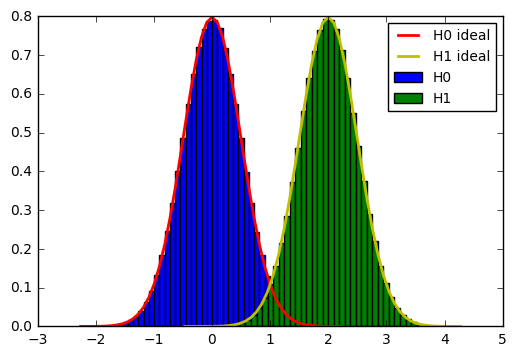

In [5]:
_, bins_0, _ = plt.hist(H0, 50, normed=True, label='H0')
_, bins_1, _ = plt.hist(H1, 50, normed=True, label='H1')
plt.plot(bins_0, 1/(sigma_H0 * np.sqrt(2 * np.pi)) * np.exp( - (bins_0 - mu_H0)**2 / (2 * sigma_H0**2) ), 
         linewidth=2, color='r', label='H0 ideal')
plt.plot(bins_1, 1/(sigma_H1 * np.sqrt(2 * np.pi)) * np.exp( - (bins_1 - mu_H1)**2 / (2 * sigma_H1**2) ), 
         linewidth=2, color='y', label='H1 ideal')
plt.legend(fontsize=10)
plt.show()

Merge and shuffle them, use VAE to train on data

In [6]:
data = np.concatenate((H0, H1), axis=0)
np.random.shuffle(data)

In [7]:
def vae_train(sess, optimizer, cost, x, n_samples, batch_size=100, learn_rate=0.001, train_epoch=10, verb=1, verb_step=5):
    start_time = time.time()
    
    for epoch in range(train_epoch):
        avg_cost = 0
        total_batch = int(n_samples / batch_size)
        for i in range(total_batch):
            batch_x = data[i*batch_size:(i+1)*batch_size]
            
            _, c = sess.run((optimizer, cost), feed_dict={x: batch_x})
            avg_cost += c / n_samples * batch_size
            elapsed_time = (time.time() - start_time)* 1000 / verb_step
            start_time = time.time()
        
        if verb:
            if epoch % verb_step == 0:
                print('Epoch:%04d' % (epoch+1), 'cost=', '{:.9f}'.format(avg_cost), 'Elapsed time: ','%.9f' % elapsed_time)

In [8]:
config = {}
config['x_in'] = 1
config['encoder_1'] = 1
config['encoder_2'] = 1
config['decoder_1'] = 1
config['decoder_2'] = 1
config['z'] = 2
batch_size = 50000
(sess, optimizer, cost, x, x_prime) = vae_init(batch_size=batch_size, config=config)

In [9]:
vae_train(sess, optimizer, cost, x, n_samples*2, batch_size=batch_size, learn_rate=0.00001, train_epoch=26)

Epoch:0001 cost= 1.134330627
Epoch:0006 cost= 0.826238751
Epoch:0011 cost= 0.655705886
Epoch:0016 cost= 0.545463741
Epoch:0021 cost= 0.440110976
Epoch:0026 cost= 0.326812333


### Reconstruct Data

In [10]:
total_batch = int(n_samples*2 / batch_size)
data_reconstruct = []
for i in range(total_batch):
    data_reconstruct.append(sess.run(x_prime,  feed_dict={x: data[i*batch_size:(i+1)*batch_size]}))
data_reconstruct = np.concatenate(data_reconstruct, axis=0)

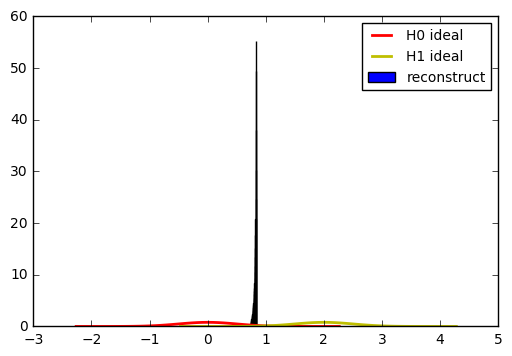

In [11]:
_, bins, _ = plt.hist(data_reconstruct, bins=50, normed=True, label='reconstruct')
plt.plot(bins_0, 1/(sigma_H0 * np.sqrt(2 * np.pi)) * np.exp( - (bins_0 - mu_H0)**2 / (2 * sigma_H0**2) ), 
         linewidth=2, color='r', label='H0 ideal')
plt.plot(bins_1, 1/(sigma_H1 * np.sqrt(2 * np.pi)) * np.exp( - (bins_1 - mu_H1)**2 / (2 * sigma_H1**2) ), 
         linewidth=2, color='y', label='H1 ideal')
plt.legend(fontsize=10)
plt.show()

### 2D Gaussian

Generate synthetic data with two classes:  
$H0 \sim \mathcal{N}((0,0), (0.3,0.3))$  
$H1 \sim \mathcal{N}((2,2), (0.1,0.9))$  
Each of them have 10000 samples

In [12]:
mu_H0, sigma_H0 = (0,0), [[0.3,0],[0,0.3]]
mu_H1, sigma_H1 = (2,2), [[0.1,0],[0,0.9]]
n_samples = 500000
H0 = np.random.multivariate_normal(mu_H0, sigma_H0, n_samples).reshape((-1,2))
H1 = np.random.multivariate_normal(mu_H1, sigma_H1, n_samples).reshape((-1,2))
H0_label = np.zeros((n_samples, 1))
H0_label = np.ones((n_samples, 1))

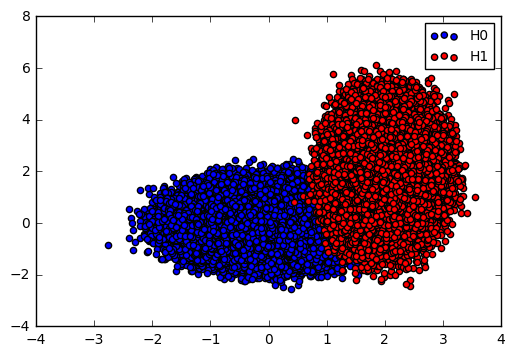

In [13]:
plt.scatter(H0[:,0], H0[:,1], c='b', label='H0')
plt.scatter(H1[:,0], H1[:,1], c='r', label='H1')
plt.legend(fontsize=10)
plt.show()

In [14]:
data = np.concatenate((H0, H1), axis=0)
np.random.shuffle(data)

In [15]:
def vae_train(sess, optimizer, cost, x, n_samples, batch_size=100, learn_rate=0.001, train_epoch=10, verb=1, verb_step=5):
    start_time = time.time()
    for epoch in range(train_epoch):
        avg_cost = 0
        total_batch = int(n_samples / batch_size)
        for i in range(total_batch):
            batch_x = data[i*batch_size:(i+1)*batch_size,:]
            
            _, c = sess.run((optimizer, cost), feed_dict={x: batch_x})
            avg_cost += c / n_samples * batch_size
            elapsed_time = (time.time() - start_time)* 1000 / verb_step
            start_time = time.time()
        
        if verb:
            if epoch % verb_step == 0:
                print('Epoch:%04d' % (epoch+1), 'cost=', '{:.9f}'.format(avg_cost), 'Elapsed time: ','%.9f' % elapsed_time)

In [16]:
config = {}
config['x_in'] = 2
config['encoder_1'] = 1
config['encoder_2'] = 1
config['decoder_1'] = 1
config['decoder_2'] = 1
config['z'] = 2
batch_size = 10000
(sess, optimizer, cost, x, x_prime) = vae_init(batch_size=batch_size, config=config)

In [17]:
vae_train(sess, optimizer, cost, x, n_samples*2, batch_size=batch_size, learn_rate=0.001, train_epoch=26)

Epoch:0001 cost= 2.672117543 Elapsed time:  1.045799255
Epoch:0006 cost= 1.243471875 Elapsed time:  1.059913635
Epoch:0011 cost= 0.822557305 Elapsed time:  0.965213776
Epoch:0016 cost= 0.618897207 Elapsed time:  1.019048691
Epoch:0021 cost= 0.474472529 Elapsed time:  0.955247879
Epoch:0026 cost= 0.354514093 Elapsed time:  0.976896286


### Reconstruct Data

In [18]:
total_batch = int(n_samples*2 / batch_size)
data_reconstruct = []
for i in range(total_batch):
    data_reconstruct.append(sess.run(x_prime,  feed_dict={x: data[i*batch_size:(i+1)*batch_size,:]}))
data_reconstruct = np.concatenate(data_reconstruct, axis=0)

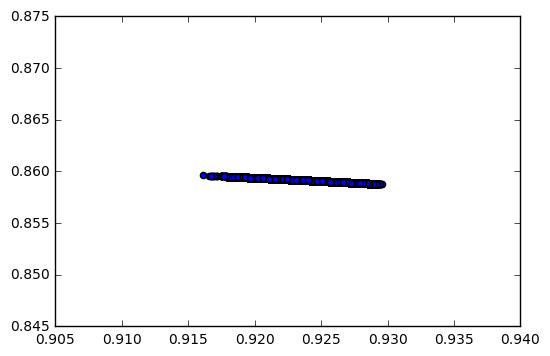

In [19]:
plt.scatter(data_reconstruct[:,0], data_reconstruct[:,1])
plt.show()

### Conclusion

Since Variational autoencoder is designed to find low dimensional manifold for higher dimensional data, it does not perform very well on low dimensional "easy" (Gaussian) data. From the two examples shown above, the VAE cannot reproduce similar dataset.  
However, for a more complex data (e.g. MNIST dataset, which we will shown in another ipynb) with higher dimension and more texture, the VAE can actually perform well on it.